<h1 style="text-align:center;font-size:30px;" > Demand Forecasting for a Store </h1>

<h1>Hyper-parameter tuning

<h3>Importing libraries

In [1]:
# Importing useful libraries
import pandas as pd
import seaborn as sb
from matplotlib import pyplot as plt
import numpy as np
import time
import os
%matplotlib inline 

In [2]:
os.chdir("D:\AAAAAAA RAJSHREE\DATA SCIENCE\DATASETs\Demand forecasting for a store")

<h3>Loading files

In [3]:
#Reading csv file using pandas
train = pd.read_csv("train.csv")
center = pd.read_csv("fulfilment_center_info.csv")
meal = pd.read_csv("meal_info.csv")
#Merging dataframes using "merge" function
df = train.merge(meal, on="meal_id")
df = df.merge(center, on="center_id")

In [4]:
# As the data is a time series data
# Sorting the dataframe wrt week
df = df.sort_values(by="week")
# One hot Encoding to categorical columns - "category", "cuisine" and "center_type"
df = pd.get_dummies(df)
df.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,category_Seafood,category_Soup,category_Starters,cuisine_Continental,cuisine_Indian,cuisine_Italian,cuisine_Thai,center_type_TYPE_A,center_type_TYPE_B,center_type_TYPE_C
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,...,0,0,0,0,0,0,1,0,0,1
284804,1409622,1,113,2444,658.63,660.63,0,0,14,680,...,1,0,0,1,0,0,0,0,0,1
285005,1203879,1,113,1525,244.50,282.33,0,0,14,680,...,0,0,0,0,0,0,1,0,0,1
285106,1235654,1,113,2704,242.50,280.33,0,0,121,680,...,0,0,0,0,0,0,1,0,0,1
43263,1393327,1,52,1248,247.35,247.35,0,0,81,685,...,0,0,0,0,1,0,0,0,1,0


<h3>Removing outliers

In [5]:
# Calculating quartile 1 and quartile 3 of log of the column num_orders
q1 = np.percentile(np.log(df["num_orders"]),25)
q3 = np.percentile(np.log(df["num_orders"]),75)
#Calculating Inter Quartile Region
iqr = q3-q1
# Removing the data points which are less than and greater than q1-1.5*iqr and q3+1.5*iqr respectively
df = df[np.log(df["num_orders"])>=q1-1.5*iqr]
df = df[np.log(df["num_orders"])<=q3+1.5*iqr]
# Also removing the data points whose checkout_price is greater than 800
df = df[df["checkout_price"]<800]

In [6]:
# Adding an engineered feature "discount_percentage"
df["discount_percentage"] = (df["base_price"]-df["checkout_price"])*100/df["base_price"]
# Converting all column names to lower case
df = df.rename(columns=str.lower)
# Removing column "id" and "checkout_price" 
df = df.drop(["id","checkout_price","base_price","city_code","region_code"],axis=1)
df

,week,center_id,meal_id,emailer_for_promotion,homepage_featured,num_orders,op_area,category_beverages,category_biryani,category_desert,...,category_soup,category_starters,cuisine_continental,cuisine_indian,cuisine_italian,cuisine_thai,center_type_type_a,center_type_type_b,center_type_type_c,discount_percentage
0,1,55,1885,0,0,177,2.0,1,0,0,...,0,0,0,0,0,1,0,0,1,10.151684
284804,1,113,2444,0,0,14,4.0,0,0,0,...,0,0,1,0,0,0,0,0,1,0.302741
285005,1,113,1525,0,0,14,4.0,0,0,0,...,0,0,0,0,0,1,0,0,1,13.399214
285106,1,113,2704,0,0,121,4.0,0,0,0,...,0,0,0,0,0,1,0,0,1,13.494810
43263,1,52,1248,0,0,81,5.6,1,0,0,...,0,0,0,1,0,0,0,1,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287668,145,145,1778,1,0,378,3.9,1,0,0,...,0,0,0,0,1,0,1,0,0,0.018741
350483,145,59,1445,0,1,40,4.2,0,0,0,...,0,0,1,0,0,0,1,0,0,-0.137641
262083,145,73,1770,0,0,55,4.0,0,1,0,...,0,0,0,1,0,0,1,0,0,0.452100
448468,145,51,2304,0,0,80,7.0,0,0,1,...,0,0,0,1,0,0,1,0,0,0.206173


In [7]:
# Separating dependent and independent variables
# Assigning column "num_orders" to dependent_variable
dependent_variable = "num_orders"
# Assigning the list of columns to independent_variable
independent_variable = df.columns.tolist()
# Removing dependent_variable from the list of column in independent_variable
independent_variable.remove(dependent_variable)
# Assigning the values of independent and dependent variables to x and y respectively.
x = df[independent_variable].values
y = df[dependent_variable].values

In [8]:
# Importing all the required libraries
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet,SGDRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

In [9]:
# Splitting the data with TimeSeriesSplit
# Older data are assigned for training purpose and the recent data for testing
tss = TimeSeriesSplit(n_splits=5)
for i,j in tss.split(x):
    x_train, x_test = x[i], x[j]
    y_train, y_test = y[i], y[j]
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((380201, 28), (76040, 28), (380201,), (76040,))

<h2>Hyper-parameter tuning on XGBoost

In [10]:
# Building DMatrices
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)

In [11]:
# Default parameters of XGBoost
params = {'max_depth': 7,
 'min_child_weight': 6,
 'eta': 0.2,
 'subsample': 1.0,
 'colsample_bytree': 0.6,
 'eval_metric': 'rmse',
 'objective': 'reg:squarederror'}

In [12]:
# Assigning the number of boosting round to a large value
num_boost_round = 999

In [13]:
# Training the data with default parameters of XGBoost
# Evaluation is done on test data after each boosting round
# Also printing the minimum rmse value after every round till it gets the minimum rmse
# 10 boosting rounds are performed after getting the minimum rmse
s=time.time()
model = xgb.train(params,dtrain,num_boost_round=num_boost_round,\
                  evals=[(dtest, "Test")],early_stopping_rounds=10)
print("Best RMSE with default parameters: {:.2f} with {} rounds".
      format(model.best_score, model.best_iteration+1))
print("Time taken:",round(time.time()-s),"sec")

[0]	Test-rmse:360.73801
[1]	Test-rmse:318.78104
[2]	Test-rmse:289.82611
[3]	Test-rmse:266.51807
[4]	Test-rmse:243.78598
[5]	Test-rmse:227.38359
[6]	Test-rmse:219.69604
[7]	Test-rmse:212.00105
[8]	Test-rmse:205.74228
[9]	Test-rmse:203.40356
[10]	Test-rmse:199.55965
[11]	Test-rmse:195.39481
[12]	Test-rmse:192.47954
[13]	Test-rmse:189.97002
[14]	Test-rmse:188.00401
[15]	Test-rmse:184.54964
[16]	Test-rmse:181.13115
[17]	Test-rmse:179.04805
[18]	Test-rmse:177.31361
[19]	Test-rmse:176.04547
[20]	Test-rmse:175.11713
[21]	Test-rmse:173.66524
[22]	Test-rmse:172.81717
[23]	Test-rmse:170.75838
[24]	Test-rmse:170.14300
[25]	Test-rmse:168.04483
[26]	Test-rmse:166.76605
[27]	Test-rmse:166.13568
[28]	Test-rmse:165.72603
[29]	Test-rmse:165.21016
[30]	Test-rmse:164.67406
[31]	Test-rmse:164.14041
[32]	Test-rmse:163.08936
[33]	Test-rmse:162.92699
[34]	Test-rmse:162.44063
[35]	Test-rmse:162.30467
[36]	Test-rmse:162.23108
[37]	Test-rmse:162.11765
[38]	Test-rmse:161.53998
[39]	Test-rmse:161.16197
[40]	Test-

<h3>1. Tuning max_depth and min_child_weight

In [14]:
s=time.time()
# Forming parameters for gridsearch
gridsearch_params = [(max_depth, min_child_weight)
                     for max_depth in range(8,11)
                     for min_child_weight in range(6,9)]
# Defining initial best params and minimum RMSE
min_rmse = float("Inf")
best_params = None
# Iterating each value gridsearch params
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(max_depth,min_child_weight))
    # Updating parameters
    params['max_depth'],params['min_child_weight']=max_depth,min_child_weight
    # Running CV
    cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,\
                        metrics={'rmse'},early_stopping_rounds=10)
    # Updating best RMSE and boosting rounds
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    # Updating min_rmse and best_params
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))
print("Time taken:",round(time.time()-s),"sec")

CV with max_depth=8, min_child_weight=6
	RMSE 114.5517946 for 996 rounds
CV with max_depth=8, min_child_weight=7
	RMSE 114.56742100000001 for 997 rounds
CV with max_depth=8, min_child_weight=8
	RMSE 114.7867034 for 998 rounds
CV with max_depth=9, min_child_weight=6
	RMSE 113.1834092 for 998 rounds
CV with max_depth=9, min_child_weight=7
	RMSE 112.99832280000001 for 996 rounds
CV with max_depth=9, min_child_weight=8
	RMSE 112.75213779999999 for 998 rounds
CV with max_depth=10, min_child_weight=6
	RMSE 112.3204926 for 933 rounds
CV with max_depth=10, min_child_weight=7
	RMSE 112.1137606 for 853 rounds
CV with max_depth=10, min_child_weight=8
	RMSE 112.14361120000001 for 938 rounds
Best params: 10, 7, RMSE: 112.1137606
Time taken: 4154 sec


In [15]:
# Updating the parameters with the best parameters found above
params["max_depth"] = best_params[0]
params["min_child_weight"] = best_params[1]
params

{'max_depth': 10,
 'min_child_weight': 7,
 'eta': 0.2,
 'subsample': 1.0,
 'colsample_bytree': 0.6,
 'eval_metric': 'rmse',
 'objective': 'reg:squarederror'}

<h3>2. Tuning subsample and colsample_bytree

In [16]:
s=time.time()
gridsearch_params = [(subsample, colsample)
                     for subsample in [i/10. for i in range(7,11)]
                     for colsample in [i/10. for i in range(7,11)]]
# Assigning min_rmse to a large value
min_rmse = float("Inf")
# Assigning best_params to value None
best_params = None
# Iterating from the largest value and to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(subsample, colsample))
    # Updating our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Running CV
    cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,\
                        metrics={'rmse'},early_stopping_rounds=10)
    # Updating best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))
print("Time taken:",round(time.time()-s),"sec")

CV with subsample=1.0, colsample=1.0
	RMSE 114.24959559999999 for 771 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 113.3112626 for 652 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 113.07176359999998 for 673 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 112.6499514 for 629 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 114.65166500000001 for 567 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 113.71276399999999 for 668 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 113.9421034 for 491 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 112.3289566 for 708 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 115.23900900000001 for 619 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 114.481131 for 486 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 114.25051579999999 for 583 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 113.716693 for 586 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 115.88562499999998 for 570 rounds
CV with subsample=0.7, colsample=0.9
	RMSE 

In [17]:
# Updating the parameters with the best parameters found above
params["subsample"] = best_params[0]
params["colsample_bytree"] = best_params[1]
params

{'max_depth': 10,
 'min_child_weight': 7,
 'eta': 0.2,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'eval_metric': 'rmse',
 'objective': 'reg:squarederror'}

<h3>3. Tuning ETA (learning rate)

In [18]:
s=time.time()
%time
# Assigning min_rmse to a large value
min_rmse = float("Inf")
# Assigning best_params to value None
best_params = None
# Iterating each values
for eta in [.3, .2, .1, 0.01]:
    print("CV with eta={}".format(eta))
    # Updating parameters
    params['eta'] = eta
    # Running CV
    %time cv_results = xgb.cv(params,dtrain,num_boost_round=num_boost_round,seed=42,nfold=5,\
                              metrics=['rmse'],early_stopping_rounds=10)
    # Updating best score with its boost_rounds
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    # Checking whether mean_rmse is less than min_rmse
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))
print("Time taken:",round(time.time()-s),"sec")

Wall time: 0 ns
CV with eta=0.3
Wall time: 3min 19s
	RMSE 115.8706438 for 292 rounds

CV with eta=0.2
Wall time: 7min 50s
	RMSE 112.3289566 for 708 rounds

CV with eta=0.1
Wall time: 10min 54s
	RMSE 111.0995682 for 998 rounds

CV with eta=0.01
Wall time: 11min 52s
	RMSE 124.2360978 for 998 rounds

Best params: 0.1, RMSE: 111.0995682
Time taken: 2038 sec


<h2>Best parameters

In [19]:
# Updating the parameters with the best parameters found above
params["eta"] = best_params
params

{'max_depth': 10,
 'min_child_weight': 7,
 'eta': 0.1,
 'subsample': 0.9,
 'colsample_bytree': 0.7,
 'eval_metric': 'rmse',
 'objective': 'reg:squarederror'}

<h3>Training with the best parameters

In [20]:
# Training the data with the best parameters found above
s=time.time()
model = xgb.train(params,dtrain,num_boost_round=num_boost_round,evals=[(dtest, "Test")],\
                  early_stopping_rounds=10)
print("Best RMSE: {:.2f} in {} rounds".format(model.best_score, model.best_iteration+1))
print("Time taken:",round(time.time()-s),"sec")

[0]	Test-rmse:379.58655
[1]	Test-rmse:350.65079
[2]	Test-rmse:327.60996
[3]	Test-rmse:308.65219
[4]	Test-rmse:290.27097
[5]	Test-rmse:273.47833
[6]	Test-rmse:260.84430
[7]	Test-rmse:248.10150
[8]	Test-rmse:237.11594
[9]	Test-rmse:225.46370
[10]	Test-rmse:216.38182
[11]	Test-rmse:208.81363
[12]	Test-rmse:203.08417
[13]	Test-rmse:197.72604
[14]	Test-rmse:191.90758
[15]	Test-rmse:187.23770
[16]	Test-rmse:182.31009
[17]	Test-rmse:177.86266
[18]	Test-rmse:176.23517
[19]	Test-rmse:173.40926
[20]	Test-rmse:172.37857
[21]	Test-rmse:170.82481
[22]	Test-rmse:168.69064
[23]	Test-rmse:167.28955
[24]	Test-rmse:165.09786
[25]	Test-rmse:163.93901
[26]	Test-rmse:163.06064
[27]	Test-rmse:161.96995
[28]	Test-rmse:161.10773
[29]	Test-rmse:160.27437
[30]	Test-rmse:159.30039
[31]	Test-rmse:158.41281
[32]	Test-rmse:158.20029
[33]	Test-rmse:157.14786
[34]	Test-rmse:156.68054
[35]	Test-rmse:156.23157
[36]	Test-rmse:155.95924
[37]	Test-rmse:155.24141
[38]	Test-rmse:154.49748
[39]	Test-rmse:154.23564
[40]	Test-

In [21]:
# Training the data with the best parameters found above 
# This time number of boosting round is set till we get the minimum rmse value
# So we do not need the early stopping round this time
s=time.time()
num_boost_round = model.best_iteration + 1
best_model = xgb.train(params,dtrain,num_boost_round=num_boost_round,evals=[(dtest, "Test")])
print("Time taken:",round(time.time()-s),"sec")

[0]	Test-rmse:379.58655
[1]	Test-rmse:350.65079
[2]	Test-rmse:327.60996
[3]	Test-rmse:308.65219
[4]	Test-rmse:290.27097
[5]	Test-rmse:273.47833
[6]	Test-rmse:260.84430
[7]	Test-rmse:248.10150
[8]	Test-rmse:237.11594
[9]	Test-rmse:225.46370
[10]	Test-rmse:216.38182
[11]	Test-rmse:208.81363
[12]	Test-rmse:203.08417
[13]	Test-rmse:197.72604
[14]	Test-rmse:191.90758
[15]	Test-rmse:187.23770
[16]	Test-rmse:182.31009
[17]	Test-rmse:177.86266
[18]	Test-rmse:176.23517
[19]	Test-rmse:173.40926
[20]	Test-rmse:172.37857
[21]	Test-rmse:170.82481
[22]	Test-rmse:168.69064
[23]	Test-rmse:167.28955
[24]	Test-rmse:165.09786
[25]	Test-rmse:163.93901
[26]	Test-rmse:163.06064
[27]	Test-rmse:161.96995
[28]	Test-rmse:161.10773
[29]	Test-rmse:160.27437
[30]	Test-rmse:159.30039
[31]	Test-rmse:158.41281
[32]	Test-rmse:158.20029
[33]	Test-rmse:157.14786
[34]	Test-rmse:156.68054
[35]	Test-rmse:156.23157
[36]	Test-rmse:155.95924
[37]	Test-rmse:155.24141
[38]	Test-rmse:154.49748
[39]	Test-rmse:154.23564
[40]	Test-

<h3>Feature importance

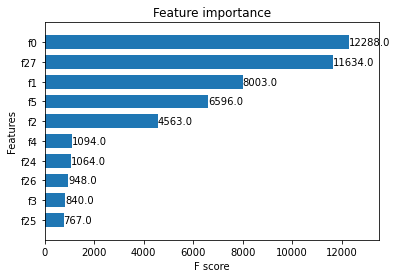

In [22]:
# Plotting feature importance graph for the first 10 features.
xgb.plot_importance(best_model, height=0.7, grid=False, max_num_features=10)
plt.show()

<h3>Prediction and error

In [23]:
# Prediction is done on train and test data and errors are compared to check for overfitting.
# As the difference between the errors are not far apart the model doesn't overfit
# Model is performing good with an accuracy of 80% on unseen data

# Calculating train error after prediction
RMSE_train = round(np.sqrt(mean_squared_error(y_train,best_model.predict(dtrain))),3)
# Calculating accuracy for the prediction done on train data
R2_train = round(r2_score(y_train,best_model.predict(dtrain)),3)

# Calculating test error after prediction
RMSE_test = round(np.sqrt(mean_squared_error(y_test,best_model.predict(dtest))),3)
# Calculating accuracy for the prediction done on test data
R2_test = round(r2_score(y_test,best_model.predict(dtest)),3)

print("         Train         Test")
print("________________________________")
print(" RMSE:  {}      {}".format(RMSE_train, RMSE_test))
print("   R2:    {}        {}".format(R2_train, R2_test))

         Train         Test
________________________________
 RMSE:  110.081      148.316
   R2:    0.907        0.799
